In [1]:
import sys
sys.path.append('..')

from KBSA import *

In [2]:
sig = np.array([[3.506, .633*(3.506*.722)**.5], [.633*(3.506*.722)**.5, .722]])
sig_root = sqrtm(sig)
df=15

def generate_rv(theta, idx, T): 
    w= np.array([theta[0], 1-theta[0]])
    xi = T[2*idx:2*idx+2]
    L,X = sig_root@xi
    Z=np.log(theta[0]*np.exp(L)+(1-theta[0])*np.exp(X))
    return (Z, L)
    
theta = np.array([1/3]); d=1
phi, psi = .1, .1

vL_true = math.sqrt(sig[0,0])*t.ppf(phi, df=df)
dL = vL_true**2/sig[0,0]
muZ = vL_true*sig[0,1]/sig[0,0]
schur = sig[1,1]-sig[0,1]**2/sig[0,0] 
VZ=(df+dL)/(df+1)*schur
co_X= muZ+math.sqrt(VZ)*t.ppf(psi, df=df+1)
co_true=np.log(theta[0]*np.exp(vL_true)+
              (1-theta[0])*np.exp(co_X))

dvL_true = np.array([0])
dco_true = np.array([(np.exp(vL_true)-np.exp(co_X))/(theta[0]*np.exp(vL_true)+(1-theta[0])*np.exp(co_X))])

In [3]:
N = 1e5
init_v = 0
cst, cst_h1, cst_h2, cst_c = 70,2,1,.4
set_v, set_co, bound_D = [-3,0],[-3,0],1

# 1) one round of the algorithm implementation

In [4]:
with np.errstate(invalid='raise'):
    try:
        T=t.rvs(df=df,size=2*int(N))
        co, v, Dv, Dco = sensitivity(N, psi, phi, d, theta, generate_rv, init_v,
                                    cst, cst_h1, cst_h2, cst_c,
                                    set_v, set_co, bound_D, crn=True, T=T)
        print('-'*40)
        print('Estimate')
        print('VaR:', round(v[-1], 3))
        print('DVaR:', [round(Dv[-1][j], 3) for j in range(d)])
        print('CoVaR:', round(co[-1],3))
        print('DCoVaR:', [round(Dco[-1][j], 3) for j in range(d)])
        
        print('-'*40)
        print('True Value')
        print('VaR:', round(vL_true, 3))
        print('DVaR:', [round(dvL_true[j], 3) for j in range(d)])
        print('CoVaR:', round(co_true,3))
        print('DCoVaR:', [round(dco_true[j], 3) for j in range(d)])
        print('-'*40)
    except (FloatingPointError, ZeroDivisionError):
        print('Error: Division by Zero')

----------------------------------------
Estimate
VaR: -2.534
DVaR: [-0.003]
CoVaR: -1.829
DCoVaR: [-0.751]
----------------------------------------
True Value
VaR: -2.51
DVaR: [0]
CoVaR: -1.84
DCoVaR: [-0.732]
----------------------------------------


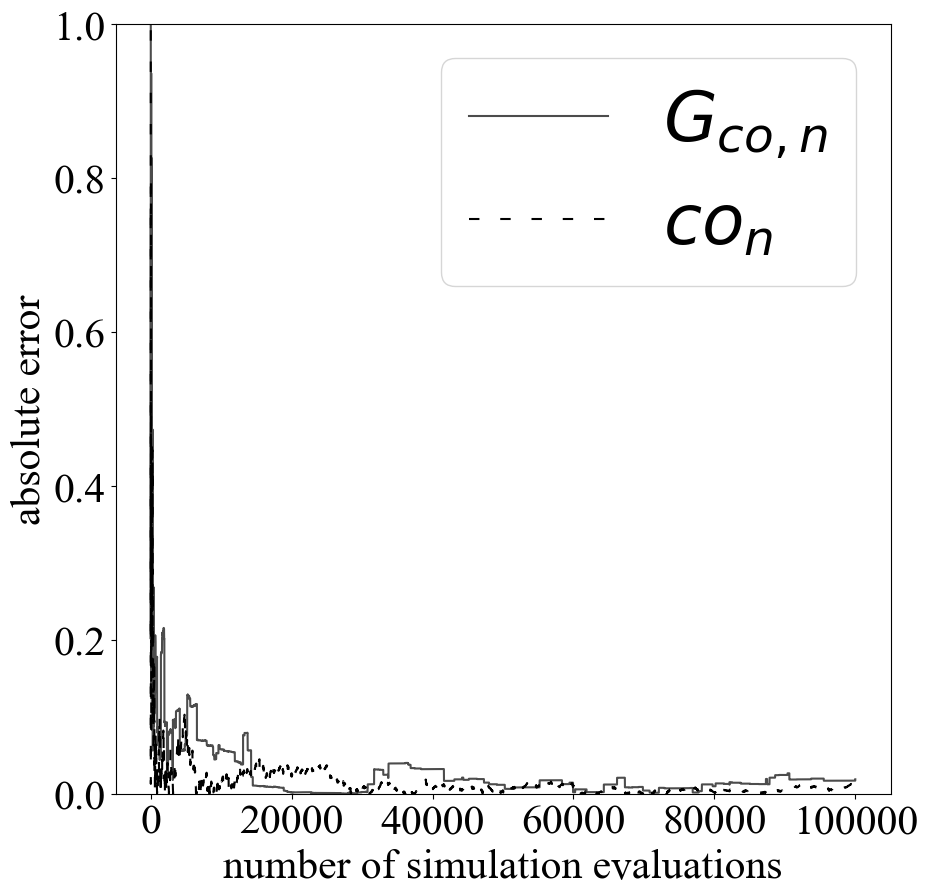

In [5]:
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = [np.linalg.norm(Dco[i]-dco_true)/d**.5 for i in range(len(Dco))]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

error = [abs(co_-co_true) for co_ in co]
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = (0,(5,10)))

plt.ylim(0,1)
plt.legend(fontsize=50)
plt.ylabel('absolute error')
plt.xlabel('number of simulation evaluations')
plt.show()

# 2) 100 independent replications

### implementation & save results

In [ ]:
cst=50
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                                             cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D, crn=True,df=df)
with open('../results/allocate_log50.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=70
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                                             cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D, crn=True,df=df)
with open('../results/allocate_log70.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

In [ ]:
cst=90
co_lst, v_lst, Dv_lst, Dco_lst = replication(N, psi, phi, d, theta, generate_rv, init_v,
                                             cst, cst_h1, cst_h2, cst_c, set_v, set_co, bound_D, crn=True,df=df)
with open('../results/allocate_log90.pkl', 'wb') as file: 
    joblib.dump([co_lst, v_lst, Dv_lst, Dco_lst], file) 

### descriptive statistics

In [13]:
# with open('../results/allocate_log50.pkl', 'rb') as f:
with open('../results/allocate_log70.pkl', 'rb') as f:
# with open('../results/allocate_log90.pkl', 'rb') as f:
    co_lst, v_lst, Dv_lst, Dco_lst = pickle.load(f)

In [14]:
mean_lst_co = np.mean(co_lst, axis=0)
mean_lst_Dco = np.mean(Dco_lst, axis=0)

bias_lst_co = [m-co_true for m in mean_lst_co]
bias_lst_Dco = [m-dco_true for m in mean_lst_Dco]

In [16]:
AE_lst_co = [[abs(i-co_true) for i in co_lst[j]] for j in range(len(co_lst))]
MAE_lst_co = np.mean(AE_lst_co, axis=0)

AE_lst_Dco = [[np.linalg.norm(i-dco_true) for i in Dco_lst[j]] for j in range(len(Dco_lst))]
MAE_lst_Dco = np.mean(AE_lst_Dco, axis=0)

In [17]:
SE_lst_co = [[abs(i-co_true)**2 for i in co_lst[j]] for j in range(len(co_lst))]
RMSE_lst_co = np.mean(SE_lst_co, axis=0)**.5

SE_lst_Dco = [[np.linalg.norm(i-dco_true)**2 for i in Dco_lst[j]] for j in range(len(Dco_lst))]
RMSE_lst_Dco = np.mean(SE_lst_Dco, axis=0)**.5

In [18]:
print('CoVaR estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_co[k]/np.linalg.norm(co_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_co[k],2))
    print('bias:', round(bias_lst_co[k],4))
    print('RMSE: ',round(RMSE_lst_co[k],2))

CoVaR estimation
----- 100 -----
relative error:  13.02 %
MAE:  0.24
bias: 0.1158
RMSE:  0.29
----- 1000 -----
relative error:  5.66 %
MAE:  0.1
bias: 0.0444
RMSE:  0.13
----- 10000 -----
relative error:  1.67 %
MAE:  0.03
bias: 0.0097
RMSE:  0.04
----- 100000 -----
relative error:  0.72 %
MAE:  0.01
bias: -0.0035
RMSE:  0.02


In [19]:
print('CoVaR gradient estimation')
for k in [1e2,1e3,1e4,1e5]:
    k=int(k)
    print('-'*5,k,'-'*5)
    print('relative error: ',round(MAE_lst_Dco[k]/np.linalg.norm(dco_true)*100,2),'%')
    print('MAE: ',round(MAE_lst_Dco[k],3))
    print('bias:', round(bias_lst_Dco[k][0],4))
    print('RMSE: ',round(RMSE_lst_Dco[k],3))

CoVaR gradient estimation
----- 100 -----
relative error:  68.59 %
MAE:  0.502
bias: 0.3714
RMSE:  0.671
----- 1000 -----
relative error:  20.09 %
MAE:  0.147
bias: 0.0247
RMSE:  0.184
----- 10000 -----
relative error:  7.36 %
MAE:  0.054
bias: -0.0024
RMSE:  0.07
----- 100000 -----
relative error:  2.56 %
MAE:  0.019
bias: 0.0055
RMSE:  0.023


### data visualization

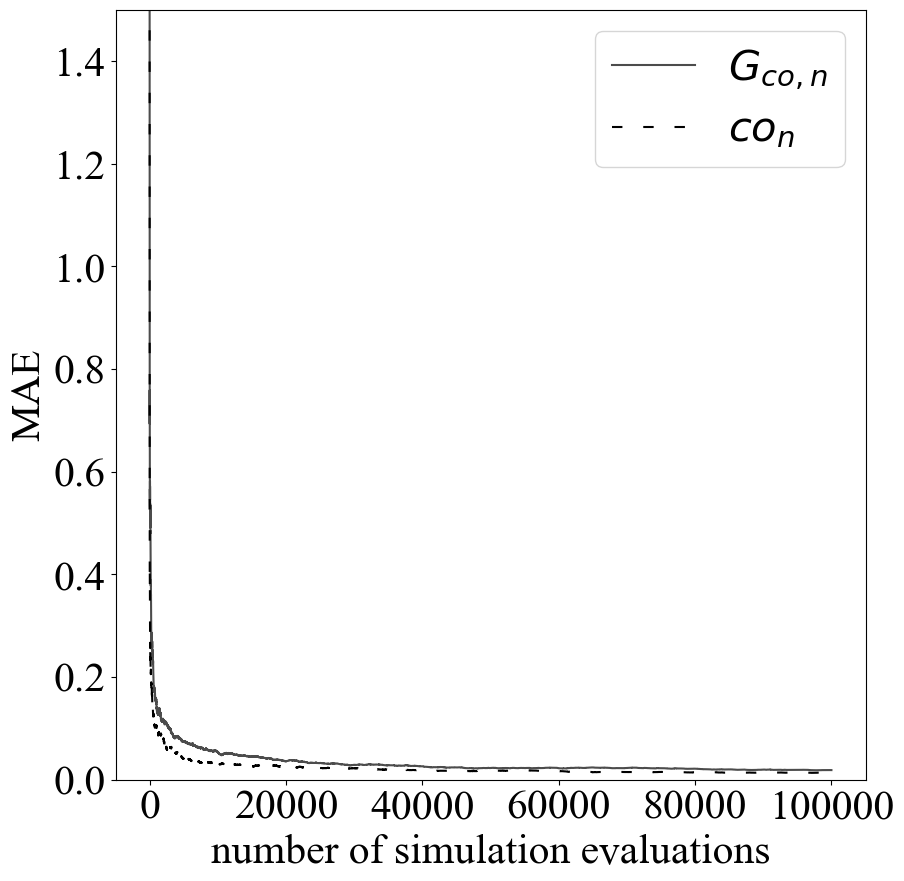

In [21]:
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = MAE_lst_Dco
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))


error = MAE_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = next(style))

plt.ylim(0,1.5)
plt.ylabel('MAE')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.xlabel('number of simulation evaluations')
plt.show()

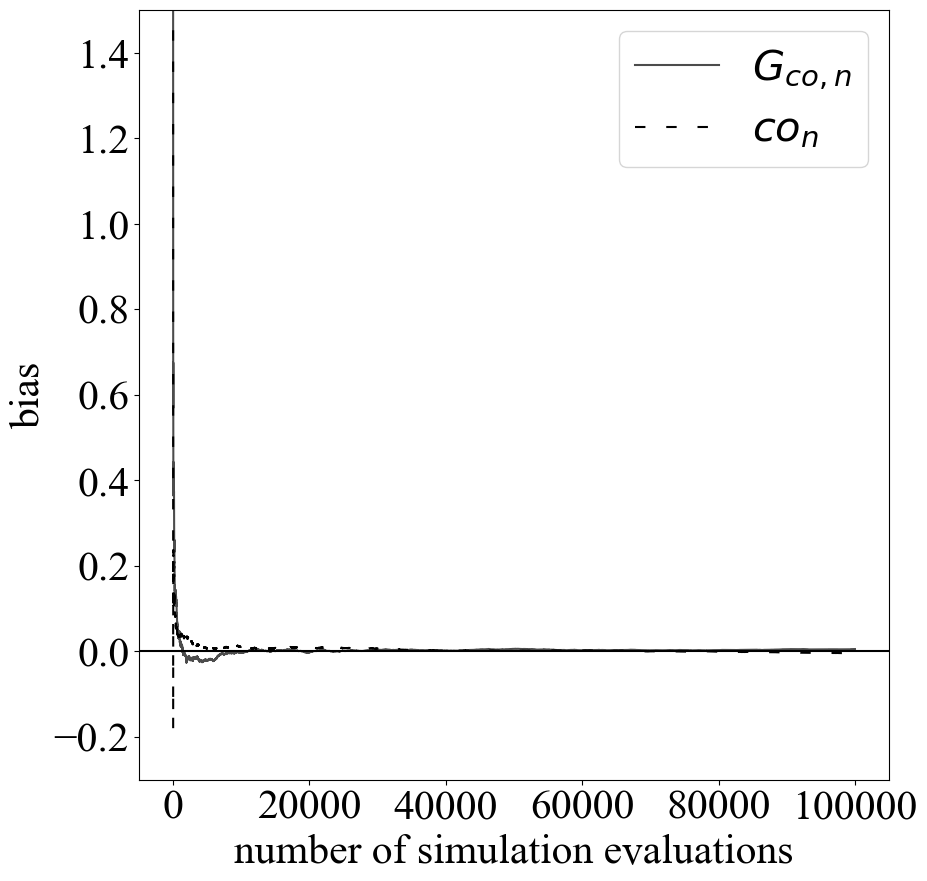

In [22]:
style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

error = bias_lst_Dco
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$G_{co,n}$', 
         alpha=.7,color='k', linestyle = next(style))

error = bias_lst_co
plt.plot(range(len(error)), error, mec='r', mfc='w', label = r'$co_{n}$', 
         alpha=1,color='k', linestyle = next(style))

plt.ylim(-.3,1.5)
plt.axhline(0, color = 'k', alpha = 1, linestyle = '-')
plt.ylabel('bias')

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.xlabel('number of simulation evaluations')
plt.show()

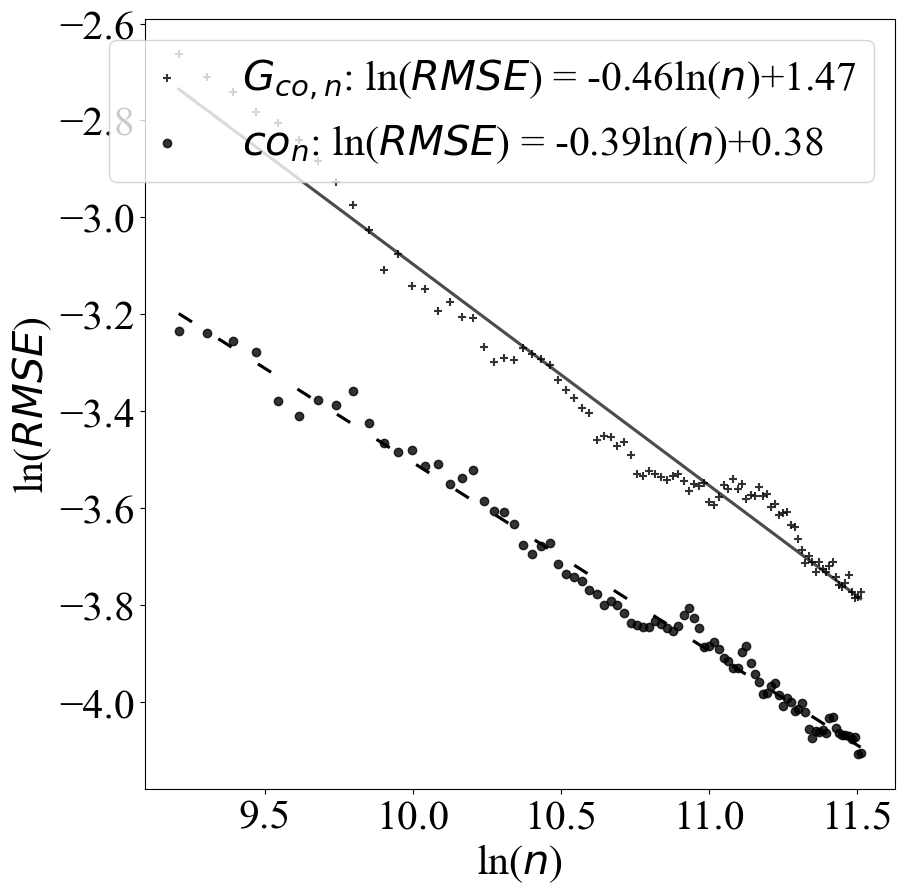

In [23]:
N=1e5
start = int(1e4)
logn = [math.log(n+1) for n in range(start, int(N+1))][::int(1e3)]

style=itertools.cycle(["-",(0,(5,10))])
plt.rc('font', size=30)

style=itertools.cycle(["-",(0,(5,10))])
y=[math.log(rmse) for rmse in RMSE_lst_Dco][start:int(N+1):int(1e3)]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y ,ci = None, 
            label =  r'$G_{co,n}$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)+'+str(round(intercept,2)),
            color='k', marker = '+', line_kws=dict(alpha = .7, color="k", linestyle = next(style)))

y=[math.log(rmse) for rmse in RMSE_lst_co][start:int(N+1):int(1e3)]
slope, intercept, r, p, sterr = scipy.stats.linregress(x=logn, y=y)
sns.regplot(x=logn, y=y, ci = None,
           label = r'$co_n$: '+'ln($RMSE$) = '+str(round(slope,2))+'ln($n$)+'+str(round(intercept,2)),
           color='k', marker = 'o', line_kws=dict(color="k", linestyle = next(style)))

plt.legend(loc='upper right')
plt.subplots_adjust(left=0.15, right=0.9)

plt.ylabel('ln($RMSE$)')
plt.xlabel('ln($n$)')
plt.show()